In [1]:
#imported required libraries

import cv2
import numpy as np 
import matplotlib.pyplot as plt  
from sklearn.cluster import KMeans

In [2]:
#image acquisition system to capture images of the cookies using a camera

def imageAcquisition():
    cam = cv2.VideoCapture(0)
    cv2.namedWindow("Cookie")

    img_counter = 0

    while True:
        ret, frame = cam.read()
        if not ret:
            print("failed to grab frame")
            break
        cv2.imshow("Cookie", frame)

        k = cv2.waitKey(1)
        if k%256 == 27:
            # ESC pressed
            print("Escape hit, closing...")

            break
        elif k%256 == 32:
            # SPACE pressed
            # Saves the image in a folder named 'image' in the same directory
            img_name = "img{}.jpg".format(img_counter)
            cv2.imwrite("image/" + img_name, frame)
            print("{} written!".format(img_name))
            img_counter += 1

    cam.release()
    cv2.destroyAllWindows()

In [3]:
# Reads the ith indexed image file from '/image' folder

def imageRead(i):
    path = 'image/'+'img'+str(i)+'.jpg'
    image = cv2.imread(path)
    return image

In [4]:
# Calculates vertical and horizontal diameter of cookie

def cookieDimensions(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (3,3), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    x,y,w,h = cv2.boundingRect(thresh)
    # crops image to it's bounding box size
    image = image[y:y+h, x:x+w]
    
    print("**************************************************************")
    print("Cookie Dimensions")
    print("\n")
    print('Vertical Diameter of Cookie is:'+str(h)+"px")
    print('Horizontal Diameter of Cookie is:'+str(w)+"px")
    print("\n")
    print("**************************************************************")
    print("\n")
    
    return image

In [5]:
# Converts RGB to hex code

def rgb_to_hex(rgb):
    return '%02x%02x%02x' % rgb


In [6]:
# Plots the top 3 hex codes of the color of the cookie

def centroid_histogram(clt):
    # grab the number of different clusters and create a histogram
    # based on the number of pixels assigned to each cluster
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins = numLabels)
    # normalize the histogram, such that it sums to one
    hist = hist.astype("float")
    hist /= hist.sum()
    # return the histogram
    return hist

def plot_colors(hist, centroids):
    # initialize the bar chart representing the relative frequency
    # of each of the colors
    bar = np.zeros((50, 300, 3), dtype = "uint8")
    startX = 0
    # loop over the percentage of each cluster and the color of
    # each cluster

    perc=np.array([1, 1, 1])
    i=0
    for (percent, color) in zip(hist, centroids):
        if not (color[0]>210 and color[1]>210 and color[2]>210):
            perc[i]=percent*100
            i=i+1
        if(i>2):
            break
    sum=perc[0]+perc[1]+perc[2]
    scale=100/sum
    loop=0
    
    print("**************************************************************")
    print("Top 3 hex codes of the color of the cookie")
    print("\n")
    
    for (percent, color) in zip(hist, centroids):
        # plot the relative percentage of each cluster
        if not (color[0]>210 and color[1]>210 and color[2]>210):
            print(color)
            endX = startX + (percent*scale * 300)
            cv2.rectangle(bar, (int(startX), 0), (int(endX), 50),color.astype("uint8").tolist(), -1)
            startX = endX
            loop=loop+1
            col=rgb_to_hex((int(color[0]), int(color[1]),int(color[2])))
            print("Color is: #"+col)
        if (loop>2):
            break
    
    # return the bar chart
    return bar

In [7]:
# Determines dominant colors in the cookie

def cookieColor(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#     # show our image
#     plt.figure()
#     plt.axis("off")
#     plt.imshow(image)

    # reshape the image to be a list of pixels
    image = image.reshape((image.shape[0] * image.shape[1], 3))

    # cluster the pixel intensities
    clt = KMeans(n_clusters = 5)
    clt.fit(image)

    # build a histogram of clusters and then create a figure
    # representing the number of pixels labeled to each color
    hist = centroid_histogram(clt)
    bar = plot_colors(hist, clt.cluster_centers_)

    # show our color bar
    plt.figure()
    plt.axis("off")
    plt.imshow(bar)
    plt.show()
    
    print("**************************************************************")
    print("\n")

In [8]:
# Non Maximal Suppression Algorithm to replace overlapping contours by their intersection over union

def non_max_suppression_fast(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes	
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))

    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick].astype("int")

def non_max_sup(image,boundingBoxes):
    orig = image.copy()
    # loop over the bounding boxes for each image and draw them
    for (startX, startY, endX, endY) in boundingBoxes:
        cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 0, 255), 2)

    # perform non-maximum suppression on the bounding boxes
    pick = non_max_suppression_fast(boundingBoxes, 0.3)
    #print "[x] after applying non-maximum, %d bounding boxes" % (len(pick))

    # loop over the picked bounding boxes and draw them
    i=0;
    for (startX, startY, endX, endY) in pick:
        cv2.rectangle(image, (startX, startY), (endX, endY), (0, 255, 0), 2)
        i=i+1

    # display the images
    
    print("**************************************************************")
    print("\n")
    plt.imshow(image[...,::-1])
    plt.show()
    
    return i

In [9]:
# Extract and determines the number of choco chips present in the cookie and plots them

def extractChocoChips(input, image):
    drawing = image

    temp = ~input
    
    # Extract contours from the thresholded image
    tmp = cv2.findContours(temp, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = tmp[0] if len(tmp) == 2 else tmp[1]
    
    count = 0
    i=0
    bb=np.array([(0,0,0,0)])
    for c in contours:
        x,y,w,h = cv2.boundingRect(c)
        area = cv2.contourArea(c)
        box_area = w*h
        # Limiting the size of choco chips/contours to be plotted
        if (area > 150 and area <5000 ):
            bb=np.append(bb,[(x,y,x+w,y+h)],axis=0)
        
        i=i+1
    number_of_chips = non_max_sup(image,bb)
    
    return number_of_chips
    
    
def countChocoChips(image,chips):
    image_copy = image.copy()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.medianBlur(image,5)
    ret,thresh = cv2.threshold(image,110,255,cv2.THRESH_BINARY)
    
    # Resized the image to a fixed width of 600 maintaining it's aspect ratio
    width = image.shape[1]
    height = image.shape[0]
    scale_percent = ((600*100)/width)

    height = int(image.shape[0] * scale_percent / 100)
    dim = (600, height)
    
    # resize thresholded image
    thresh = cv2.resize(thresh, dim, interpolation = cv2.INTER_AREA)
    image_copy = cv2.resize(image_copy, dim, interpolation = cv2.INTER_AREA)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
    
    dilate = cv2.dilate(thresh,kernel)
    dilate = cv2.dilate(dilate,kernel)
    
    input = dilate.copy()
    
    number_of_chips = extractChocoChips(input, image_copy)
    
    
    if(number_of_chips > chips):
        print("Choclate chips are sufficient")
    else:
        print("Choclate Chips are less")
    print("Number of significant Choclate chips present are:"+ str(number_of_chips))
    
    print("\n")
    print("**************************************************************")
    print("\n")

In [10]:
# Determines broken edges or any damage in the cookie

def cookieDamage(image):
    dim = None
    (h, w) = image.shape[:2]
    r = 600 / float(w)
    dim = (600, 600)
    image = cv2.resize(image, dim, interpolation =  cv2.INTER_AREA)
    blur = cv2.medianBlur(image, 5)
    gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,3)

    canny = cv2.Canny(thresh, 120, 255, 1)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    opening = cv2.morphologyEx(canny, cv2.MORPH_CLOSE, kernel)
    dilate = cv2.dilate(opening, kernel, iterations=2)

    cnts = cv2.findContours(dilate, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    min_area = 150000
    peri=0
    
    print("**************************************************************")
    print("\n")
    
    for c in cnts:
        area = cv2.contourArea(c)
        if area > min_area:
            print("Area of Contour formed is " + str(area) +"px")
            p = cv2.arcLength(c,True)
            print("Length of Contour is " + str(p) +"px")
            peri=max(peri,p)
            cv2.drawContours(image, [c], -1, (36, 255, 12), 2)
    if(peri>3000):
        print("Oops!! Cookie is damaged")
    else:
        print("Yummy!! Cookie is perfect and delicious")
    plt.figure()
    plt.axis("off")
    plt.imshow(image[...,::-1])
    
    print("**************************************************************")
    print("\n")

Enter the minimum number of required choco chips in the cookie :
8
**************************************************************
Cookie Dimensions


Vertical Diameter of Cookie is:1196px
Horizontal Diameter of Cookie is:1206px


**************************************************************


**************************************************************
Top 3 hex codes of the color of the cookie


[218.15201804 132.88985716  43.59938138]
Color is: #da842b
[51.56701461  8.18046894  6.85475759]
Color is: #330806
[238.84483557 179.8569252   91.96802257]
Color is: #eeb35b


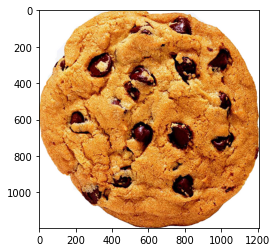

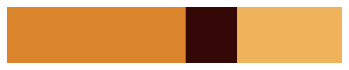

**************************************************************


**************************************************************




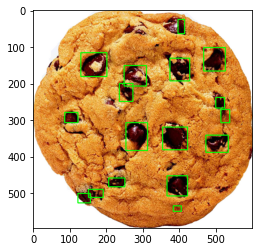

Choclate chips are sufficient
Number of significant Choclate chips present are:18


**************************************************************


**************************************************************


Area of Contour formed is 294638.5px
Length of Contour is 2071.457055091858px
Yummy!! Cookie is perfect and delicious
**************************************************************




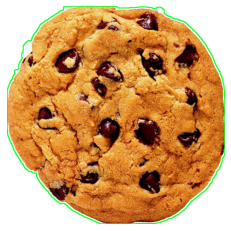

In [11]:
# Main block which call all the fuctions
# Run this block after compiling all the above functions/blocks


# imageAcquisition()
# i is the image index of the cookie to be operated on
i=1
image = imageRead(i)
image_copy = image.copy()

# Minimum number of choco chips to be prsent in the cookie (User Param)
print("Enter the minimum number of required choco chips in the cookie :")
chips=input()
chips = int(chips)

# To calculate vertcal and horizontal diameter of cookie
image = cookieDimensions(image_copy)
plt.imshow(image[...,::-1])
plt.show

# To determine hex codes of 3 dominant colors in the cookie 
cookieColor(image)

# To count number of significant choco chips in the cookie 
countChocoChips(image,chips)

# To check broken edges or any damage in the cookie
cookieDamage(image)